# Autoencoder training

In [2]:
import datetime
import json
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import tensorflow as tf

from rich import print
from sys import platform
from tensorflow import keras
from tensorflow.data import Dataset
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Convolution2D, AvgPool2D, MaxPooling2D, Convolution2DTranspose, Rescaling, UpSampling2D
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dropout, BatchNormalization, Flatten, Input, SpatialDropout2D
from tensorflow.keras.activations import relu, sigmoid, tanh
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, BinaryCrossentropy

from typing import List, Tuple

sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.color_palette("hls", 8)

%matplotlib inline

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(f"GPUs available: {tf.config.list_physical_devices('GPU')}")

#os.environ["tf_gpu_allocator"]="cuda_malloc_async"

Num GPUs Available:  1

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1.- Loading the dataset.

First, we need to load the images that will be used to train the autoencoder. The function _load_hdf5_files_ takes as inputs a direcotry path in which the hdf5 files with the images are stored, and the number of files to load within that directory. The files are randomly sampled. It returns three numpy arrays, that serve as train, validation and test datasets.

In [3]:
def load_hdf5_files(directory, n = None):
    """
    Load random HDF5 files containing images from a specified directory and concatenate them into a single NumPy array.

    Args:
        directory (str): The path to the directory containing HDF5 files.
        n (int): The number of random files to load. If n = 0, load all files.

    Returns:
        train_data: A  NumPy array containing all the images from the train dataset of the loaded HDF5 files.
        validation_data: A single NumPy array containing all the images from the validation dataset of the loaded HDF5 files.
        test_data: A single NumPy array containing all the images from the the test dataset of the loaded HDF5 files.

    The function selects 'n' random HDF5 files from the specified 'directory', reads the datasets from each
    file, and concatenates these datasets into a single NumPy array. This array contains all the images from the loaded
    HDF5 files. The function returns three arrays, one each for training, validation and test.

    Note:
    - Ensure that the HDF5 files in the directory have datasets named 'train', 'validation', and  'test' (or adjust accordingly).
    - If 'n' is greater than the number of available HDF5 files in the directory, all available files will be loaded.
    - if 'n' is not specified, all available files will be loaded

    Example usage:
    >>> directory_path = '/path/to/your/directory'
    >>> n = 3
    >>> train_data, val_data, test_data = load_random_hdf5_files(directory_path, n_files_to_load)
    """

    file_list = []
    # List all HDF5 files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".hdf5"):
            file_list.append(os.path.join(directory, filename))
    if not file_list:
        print("No HDF5 files found in the specified directory.")
        return None
    if (n > len(file_list)) or (n is None) or (n == 0):
        if n == 0:
            print(f"Requested to load all files - there are {len(file_list)} files available.")
        else:
            print(f"Requested to load {n} files, but there are only {len(file_list)} files available.")
        n = len(file_list)

    # Randomly select n files
    random_files = random.sample(file_list, n)
    train_data = []
    validation_data = []
    test_data = []
    global_max = 0
    global_min = 1e6
    # return train_data, validation_data, test_data, metadata

    for file_path in random_files:
        with h5py.File(file_path, 'r') as hf:
            # Load train, validation, and test datasets
            d1 = np.array(hf["train"], dtype = np.uint8)
            d2 = np.array(hf["validation"])
            d3 = np.array(hf["test"])
            #discard last row and column of images
            d1 = d1[:, :-1, :-1]
            d2 = d2[:, :-1, :-1]
            d3 = d3[:, :-1, :-1]
            local_max = hf.attrs['train_max']
            local_min = hf.attrs['train_min']
            if local_max > global_max:
                global_max = local_max
            if local_min < global_min:
                global_min = local_min
            train_data.append(np.array(d1))
            validation_data.append(np.array(d2))
            test_data.append(np.array(d3))

    # Concatenate the individual arrays into a single NumPy array
    train_data = np.concatenate(train_data, axis=0)
    validation_data = np.concatenate(validation_data, axis=0)
    test_data = np.concatenate(test_data, axis=0)

    img_shape = train_data[0].shape
    re_shape = (-1,) + img_shape + (1,)
    print("Sets will be of shape: {}".format(re_shape))
    print("Range scalers are (global min, global max) = {}".format([global_min, global_max]))
    train_data = train_data.reshape(re_shape)
    validation_data = validation_data.reshape(re_shape)
    test_data = test_data.reshape(re_shape)

    return train_data, validation_data, test_data, [global_min, global_max]

In [4]:
if platform == 'darwin':
    images_path = "/Users/lmiguelmartinez/Tesis/datasets/highD/images_historic_1000ms"
else:
    images_path = "/home/lmmartinez/Tesis/datasets/highD/images_historic_1000ms"

train_data, val_data, test_data, global_scalers = load_hdf5_files(images_path, n = 0)
os.makedirs('/tmp/logs', exist_ok=True)
tensorboard_log_dir = '/tmp/logs/'
IMAGE_SIZE = train_data[0].shape
print("Images are of size {}".format(IMAGE_SIZE))

Requested to load all files - there are 60 files available.

Sets will be of shape: (-1, 120, 200, 1)

Range scalers are (global min, global max) = [1.3206229756843115e-106, 117.8761944159839]

Images are of size (120, 200, 1)

### 1.1 Data Inspection

Once the data has been loaded, a few sample images are plotted to verify its integrity.

Total training  images: 41599

Total validation images: 13850

Total test images: 13926

Max and min of train data: 255, 0

Max and min of validation data: 255, 0

Max and min of test data: 255, 0

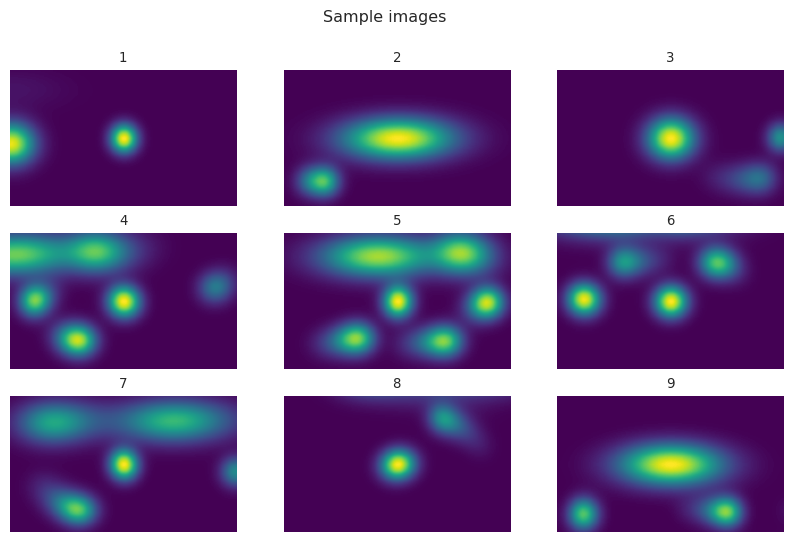

In [5]:
print('Total training  images:', len(train_data))
print('Total validation images:', len(val_data))
print('Total test images:', len(test_data))

print("Max and min of train data: {}, {}".format(np.max(train_data), np.min(train_data)))
print("Max and min of validation data: {}, {}".format(np.max(val_data), np.min(val_data)))
print("Max and min of test data: {}, {}".format(np.max(test_data), np.min(test_data)))

plot_size = 3
pic_index = np.random.randint(plot_size, np.min([len(train_data), len(val_data), len(test_data)]))

next_train = [img for img in train_data[pic_index-plot_size:pic_index]]
next_val = [img for img in val_data[pic_index-plot_size:pic_index]]
next_test = [img for img in test_data[pic_index-plot_size:pic_index]]

plt.figure(figsize=(10, 6))
for i, img in enumerate(next_train+next_val+next_test):
    plt.subplot(3, plot_size, i+1)
    plt.imshow(img, cmap = 'viridis')
    plt.title(i+1)
    plt.axis('Off')
plt.suptitle("Sample images")
plt.show()

## 2.- Model definition.

To define the autoencoder we will use four dictionaries: encoder-decoder architecture, training configuration and model parameters. The class AutoEncoder implements the necessary steps to train the Autoencoder and perform validation and testing tasks.

In [6]:
class AutoEncoder:
    def __init__(self, train_config = None, model_config = None, encoder_config = None, decoder_config = None):
        """
        Initialize an AutoEncoder instance.

        Args:
            train_config (dict): Configuration for training the model.
            model_config (dict): Configuration for the autoencoder model.
            encoder_config (dict): Configuration for the encoder part of the autoencoder.
            decoder_config (dict): Configuration for the decoder part of the autoencoder.
        """
        self.train_config = train_config
        self.encoder_config = encoder_config
        self.decoder_config = decoder_config
        self.model_config = model_config

        self.encoder = None
        self.decoder = None
        self.model = None
        self.layer_mapping = {
            'Input': None,
            'RandomFlip': RandomFlip,
            'RandomRotation': RandomRotation,
            'LSTM': LSTM,
            'GRU': GRU,
            'Conv2D': Convolution2D,
            'Deconv2D': Convolution2DTranspose,
            'MaxPooling2D': MaxPooling2D,
            'AvgPooling2D': AvgPool2D,
            'UpSampling2D': UpSampling2D,
            'Dense': Dense,
            'Flatten': Flatten,
            'Dropout': Dropout,
            'SpatialDropout2D': SpatialDropout2D,
            'BatchNormalization': BatchNormalization,
            'Rescaling': Rescaling
        }
    def buildModel(self, arch_config = None):
        """
        Build a Keras model based on the provided architecture configuration.

        Args:
            arch_config (dict): Configuration for the architecture of the model.

        Returns:
            tf.keras.models.Sequential: The constructed Keras model.
        """
        model = Sequential()
        for layer in arch_config.keys():
            layer_identifier = re.split('_', layer)[0]
            arch_config[layer]['name'] = layer
            layer_class = self.layer_mapping.get(layer_identifier)
            if layer_class:
                x = layer_class(**arch_config[layer])
                model.add(x)
        return model
    
    def buildAutoencoder(self):
        """
        Build the autoencoder model using the encoder and decoder configurations.
        """
        self.encoder = self.buildModel(arch_config=self.encoder_config)
        self.decoder = self.buildModel(arch_config=self.decoder_config)

        input_tensor = Input(shape=self.encoder_config['Input_1']['shape'])
        latent_vector = self.encoder(input_tensor)
        output = self.decoder(latent_vector)
        self.model = Model(input_tensor, output)
        self.compileModel()
        
    def compileModel(self):
        """
        Compile the autoencoder model with the specified loss function and optimizer.
        """
        loss_fun = self.model_config['loss']
        opt = self.model_config['opt']
        name = self.model_config['name']
        metrics = self.model_config['metrics']
        initial_learning_rate = self.model_config['initial_learning_rate']
        decay_rate = self.model_config['decay_rate']

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=100000,
            decay_rate=decay_rate,
            staircase=True
        )

        if opt == 'Adam':
            opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
        elif opt == 'SGD':
            opt = tf.keras.optimizers.legacy.SGD(learning_rate=lr_schedule)
        elif opt == 'Aadamax':
            opt = tf.keras.optimizers.legacy.Adamax(learning_rate=lr_schedule)

        print("Loss, optimizer and metric set up")
        self.model._name = name
        self.model.compile(loss = loss_fun, optimizer = opt, metrics = metrics)
        print("Model created:")
        self.model.summary()
        print("Model has been built")

    def trainModel(self, train_data, val_data, log_dir):
        """
        Train the autoencoder model using the provided training data.

        Args:
            train_data (numpy.ndarray): Training data.
            val_data (numpy.ndarray): Validation data.
            log_dir (str): Directory for TensorBoard logs.

        Returns:
            dict: Training history.
        """
        batch_size = self.train_config['batch_size']
        epochs = self.train_config['epochs']
        shuffle = self.train_config['shuffle']
        patience = self.train_config['ES_patience']
        min_delta = self.train_config['ES_min_delta']
        verbose = self.train_config['verbose']
        start_from = self.train_config['start_from_epoch']
        
        checkpoint_path = os.path.join(log_dir, "model_checkpoint.h5")
        checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)

        early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        verbose=1,
        min_delta = min_delta,
        start_from_epoch = start_from,
        restore_best_weights = True)

        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=4)

        history = self.model.fit(
            x=train_data,
            y=train_data,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose,
            validation_data=(val_data, val_data),
            shuffle=shuffle,
            callbacks=[checkpoint, early_stopping, tensorboard_callback],
            steps_per_epoch=None,
            validation_freq=1,
        )
        self.history = history.history

        return self.history

    def predict(self, test_set):
        """
        Generate predictions using the trained autoencoder model.

        Args:
            test_set (numpy.ndarray): Input data for making predictions.

        Returns:
            numpy.ndarray: Predicted output.
        """
        predictions = self.model.predict(test_set)
        return predictions
    
    def compare(self, test_set, num_plots = 3):
        """
        Compare original input data with reconstructed data and display the results.

        Args:
            test_set (numpy.ndarray): Test data for comparison.
            num_plots (int): Number of plots to generate for comparison.
        """
        idxs = np.random.choice(range(len(test_set)), size=num_plots)
        print(idxs)
        test_samples = np.take(test_set, idxs, axis = 0)
        predictions = self.predict(test_samples)
        
        for (img, prediction, index) in zip(test_samples, predictions, idxs):
            fig, (ax1, ax2, ax3) = plt.subplots(3,1)
            fig.set_figheight(6)
            fig.set_figwidth(8)
            # ax1 = fig.add_subplot(1, 3, 1)
            pl1 = ax1.imshow(img, cmap = 'viridis', aspect = 'auto')
            ax1.set_title("Original field")
            ax1.set_xlabel("Longitudinal coordinate")
            ax1.set_ylabel("Transversal coordinate")
            ax1.axis('Off')
            fig.colorbar(pl1, orientation = 'vertical', pad = 0.1)

            # ax2 = fig.add_subplot(1, 3, 2)
            pl2 = ax2.imshow(prediction, cmap = 'viridis', aspect = 'auto')
            ax2.set_title("Reconstructed field")
            ax2.set_xlabel("Longitudinal coordinate")
            ax2.set_ylabel("Transversal coordinate")
            ax2.axis('Off')
            fig.colorbar(pl2, orientation = 'vertical', pad = 0.1)

            # ax3 = fig.add_subplot(1, 3, 3)
            pl3 = ax3.imshow(np.subtract(img, prediction), cmap = 'seismic', aspect = 'auto')
            ax3.set_title("Reconstruction error")
            ax3.set_xlabel("Longitudinal coordinate")
            ax3.set_ylabel("Transversal coordinate")
            ax3.axis('Off')
            fig.colorbar(pl3, orientation = 'vertical', pad = 0.1)

            fig.suptitle("Images and predictions from test set - Index {}".format(index))
            fig.tight_layout()
            plt.show()

    def save_model(self, directory, file_name):
        """
        Save the trained model and configuration dictionaries to files in the specified directory.

        Args:
            directory (str): Directory path for saving files.
            file_name (str): Base name for saved files (without extension). If None, a default name will be generated.
        """
        def is_jsonable(x):
            try:
                json.dumps(x)
                return True
            except (TypeError, OverflowError):
                return False
        # Create the directory if it doesn't exist
        if not os.path.exists(directory):
            print(f"Directory {directory} does not exist. Creating...")
            os.makedirs(directory)

        if file_name is None:
            # Generate a default name based on the current date and time
            timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
            file_name = f"autoencoder_{timestamp}"
            
        # Save the model to a keras file
        model_file_path = os.path.join(directory, f"{file_name}.h5")
        self.model.save(model_file_path)
        self.encoder.save(os.path.join(directory, f"{file_name}_encoder.h5"))
        self.decoder.save(os.path.join(directory, f"{file_name}_decoder.h5"))

        # Combine all dictionaries into a single dictionary
        all_data = {
            "model_config": self.model_config,
            "encoder_config": self.encoder_config,
            "decoder_config": self.decoder_config,
            "train_config": self.train_config,
            "history": self.history if self.history else None
        }

        #Convert everything to string so that its json serializable
        for outer_key, outer_value in all_data.items():
            for inner_key, inner_value in outer_value.items():
                if not (is_jsonable(inner_value)):
                    all_data[outer_key][inner_key] = str(inner_value)

        # Save the combined dictionary as a JSON file
        configs_file = os.path.join(directory, f"{file_name}_configs.json")
        with open(configs_file, 'w') as f:
            json.dump(all_data, f, indent=4)

        print(f"Model and configs saved to {directory}")
      
        
    def plot_history(self, smoothing = 0.7):
        """
        Plot the training and validation loss, RMSE, and MAE over epochs.
        """
        def smooth(scalars, weight):  # Weight between 0 and 1
            last = scalars[0]  # First value in the plot (first timestep)
            smoothed = list()
            for point in scalars:
                smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
                smoothed.append(smoothed_val)                        # Save it
                last = smoothed_val                                  # Anchor the last smoothed value
            return smoothed
        epochs = list(range(len(self.history['loss'])))
        loss = self.history['loss']
        val_loss = self.history['val_loss']
        mae = self.history.get('mean_absolute_error', None)
        val_mae = self.history.get('val_mean_absolute_error', None)
        rmse = self.history.get('root_mean_squared_error', None)
        val_rmse = self.history.get('val_root_mean_squared_error', None)
        binary_crossentropy = self.history.get('binary_crossentropy', None)
        val_binary_crossentropy = self.history.get('val_binary_crossentropy', None)

        plt.figure(figsize=(15,8))
        plt.subplot(2, 2, 1)
        plt.title('Loss - MSE')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.plot(epochs ,loss, label='Training loss', linestyle='--', alpha = 0.5, color = 'purple')
        plt.plot(epochs, val_loss, label='Validation loss', linestyle='--', alpha = 0.5, color = 'orange')
        plt.plot(epochs, smooth(scalars=loss, weight=smoothing), label = 'Smoothed training loss', color = 'purple')
        plt.plot(epochs, smooth(scalars=val_loss, weight=smoothing), label = 'Smoothed validation loss', color = 'orange')
        plt.legend()
        plt.grid(linestyle='--', linewidth=1, alpha=0.5)

        if mae is not None:
            plt.subplot(2, 2, 2)
            plt.title('Mean Absolute Error (MAE)')
            plt.xlabel('Epoch')
            plt.ylabel('MAE')
            plt.plot(epochs, mae, label='Training loss', linestyle='--', alpha = 0.5, color = 'purple')
            plt.plot(epochs, val_mae, label='Validation loss', linestyle='--', alpha = 0.5, color = 'orange')
            plt.plot(epochs, smooth(scalars=mae, weight=smoothing), label = 'Smoothed training loss', color = 'purple')
            plt.plot(epochs, smooth(scalars=val_mae, weight=smoothing), label = 'Smoothed validation loss', color = 'orange')
            plt.legend()
            plt.grid(linestyle='--', linewidth=1, alpha=0.5)
        if rmse is not None:
            plt.subplot(2, 2, 3)
            plt.title('Root Mean Squared Error (RMSE)')
            plt.xlabel('Epoch')
            plt.ylabel('RMSE')
            plt.plot(epochs, rmse, label='Training loss', linestyle='--', alpha = 0.5, color = 'purple')
            plt.plot(epochs, val_rmse, label='Validation loss', linestyle='--', alpha = 0.5, color = 'orange')
            plt.plot(epochs, smooth(scalars=rmse, weight=smoothing), label = 'Smoothed training loss', color = 'purple')
            plt.plot(epochs, smooth(scalars=val_rmse, weight=smoothing), label = 'Smoothed validation loss', color = 'orange')
            plt.legend()
            plt.grid(linestyle='--', linewidth=1, alpha=0.5)
        if binary_crossentropy is not None:
            plt.subplot(2, 2, 4)
            plt.title('Binary Crossentropy (BC)')
            plt.xlabel('Epoch')
            plt.ylabel('BC')
            plt.plot(epochs, binary_crossentropy, label='Training loss', linestyle='--', alpha = 0.5, color = 'purple')
            plt.plot(epochs, val_binary_crossentropy, label='Validation loss', linestyle='--', alpha = 0.5, color = 'orange')
            plt.plot(epochs, smooth(scalars=binary_crossentropy, weight=smoothing), label = 'Smoothed training loss', color = 'purple')
            plt.plot(epochs, smooth(scalars=val_binary_crossentropy, weight=smoothing), label = 'Smoothed validation loss', color = 'orange')
            plt.legend()
            plt.grid(linestyle='--', linewidth=1, alpha=0.5)
        
        plt.tight_layout()
        plt.show()

Some important formulas: 
- Output size of convolution layer: $(W_o, H_o) = (\frac{W-K_x+2P_x}{S_x} + 1 ,  \frac{W-K_y+2P_y}{S_y} + 1 )$

- Output size of deconvoltion layer: $(W_o, H_o) = (S_x \cdot (W-1) + K_x - 2P_x, \quad S_y \cdot (H-1) + K_y - 2P_y)$

- Output size of pooling layer: $(W_o, H_o) = (\frac{W-K_x}{S_x} + 1 ,  \frac{W-K_y}{S_y} + 1 )$

In [7]:
def build_encoder_decoder_configs(input_size: Tuple[int], latent_space_size: Tuple[int], kernel_size: Tuple[int] = (3,3), stride: Tuple[int] = (2,2), num_filters: int = 16):
    """
    Build encoder and decoder configurations based on the provided arguments.

    Args:
        input_size (tuple): Size of the input data (height, width, channels).
        latent_space_size (tuple): Size of the latent space (height, width, channels).
        kernel_size (tuple): Size of the convolutional kernels. Default is (3, 3).
        stride (tuple): Strides for the convolutional layers. Default is (2, 2).
        num_filters (int): Number of filters for the first convolutional layer.

    Returns:
        tuple: Tuple containing encoder and decoder configurations.
    """
    # Calculate the number of conv+pooling blocks based on the input size and desired latent space size
    num_conv_pool_blocks = int(np.log2(input_size[0] / latent_space_size[0]))
    print(f"Number of conv+pooling blocks: {num_conv_pool_blocks}")
    # Calculate the number of filters for each convolutional block
    filters = [min(num_filters * 2**i, 128) for i in range(num_conv_pool_blocks)]  # Scale/descale in powers of two, capped at 512
    filters[-1] = latent_space_size[2]  # Last block has the same number of filters as the latent space
    print(f"Filters for each block: {filters}")
    
    #calculate kernel size and stride based on the input size and latent space size
    kernel_size = (input_size[0] // latent_space_size[0], input_size[1] // latent_space_size[1])
    stride = (input_size[0] // latent_space_size[0], input_size[1] // latent_space_size[1])
    print(f"Kernel size: {kernel_size}, Stride: {stride}")
    
    # Calculate pool size
    pool_size = (2, 2)  # Default pool size

    encoder_config = {
    'Input_1': {'shape': train_data[0].shape},
    'Rescaling_10': {'scale': 1./255, 'offset': 0.0}}
    
    decoder_config = {}

    # Encoder configuration
    encoder_input_shape = input_size
    for i in range(num_conv_pool_blocks):
        encoder_config[f'Conv2D_{i+1}'] = {
            'filters': filters[i],
            'kernel_size': kernel_size,
            'padding': 'same',
            'strides': stride,
            'activation': 'relu'
        }
        encoder_config[f'MaxPooling2D_{i+1}'] = {
            'pool_size': pool_size,  # Pool size as parameter
            'padding': 'same'
        }
        # Update input shape for the next layer
        encoder_input_shape = (
            encoder_input_shape[0] // 2,
            encoder_input_shape[1] // 2,
            filters[i]
        )

    # Decoder configuration
    decoder_input_shape = latent_space_size
    decoder_output_shape = input_size  # Output shape matches input shape
    for i in range(num_conv_pool_blocks):
        decoder_config[f'Deconv2D_{i+1}'] = {
            'filters': filters[-i-1],  # Reverse the order of filters
            'kernel_size': kernel_size,
            'padding': 'same',
            'strides': stride,  # Same strides as encoder
            'activation': 'relu'
        }
        decoder_config[f'UpSampling2D_{i+1}'] = {
            'size': pool_size  # Upsampling size matches pooling size
        }
        # Update input shape for the next layer
        decoder_input_shape = (
            decoder_input_shape[0] * 2,
            decoder_input_shape[1] * 2,
            filters[-i-1]
        )

    # Output layer
    decoder_config['Conv2D_1'] = {
        'filters': input_size[2],  # Output channels
        'kernel_size': (3, 3),  # Example kernel size, you can adjust it if needed
        'padding': 'same',
        'activation': 'relu'
    }

    # Set input shape for the Input layer in encoder configuration
    encoder_config['Input_1'] = {'shape': input_size}

    # Set input shape for the Input layer in decoder configuration
    decoder_config['Input_1'] = {'shape': decoder_input_shape}

    return encoder_config, decoder_config

In [8]:
model_config = {'name': "AutoEncoder1", 
                'loss': 'mean_squared_error', 
                'opt': 'Adam', 
                'initial_learning_rate': 0.008,
                'decay_rate': 0.99,
                'metrics': [RootMeanSquaredError(), MeanAbsoluteError(), BinaryCrossentropy()]}

encoder_config = {
    'Input_1': {'shape': train_data[0].shape},
    'Rescaling_10': {'scale': 1./255, 'offset': 0.0},
    'Conv2D_11': {'filters': 64, 'kernel_size': (3,5), 'padding': 'same', 'strides': (3,5), 'activation': 'relu'},
    'MaxPooling2D_11': {'pool_size': (4,4), 'padding': 'same', 'strides': (4,4)},
    'Conv2D_12': {'filters': 8, 'kernel_size': (2,2), 'padding': 'same', 'strides': (2,2), 'activation': 'relu'},
}

decoder_config = {
    'Deconv2D_22': {'filters': 8, 'kernel_size': (2,2), 'padding': 'same', 'strides': (2, 2), 'activation': 'relu'},
    'UpSampling2D_22': {'size': (4,4)},
    'Deconv2D_23': {'filters': 64, 'kernel_size': (3,5), 'padding': 'same', 'strides': (3,5), 'activation': 'relu'},
    'Conv2D_24': {'filters': 1, 'kernel_size': (1,1), 'padding': 'valid', 'strides': (1,1), 'activation': 'relu'}
}


train_config = {'batch_size': 32, 'epochs': 200, 'shuffle': True, 'ES_patience': 4, 'ES_min_delta': 1, 'verbose': 1, 'start_from_epoch': 1}

autoencoder = AutoEncoder(model_config=model_config, train_config=train_config, encoder_config=encoder_config, decoder_config=decoder_config)
autoencoder.buildAutoencoder()
autoencoder.encoder.summary()
autoencoder.decoder.summary()

2024-04-17 11:00:02.864258: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 11:00:02.864517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 11:00:02.864734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Loss, optimizer and metric set up

Model created:

Model: "AutoEncoder1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 200, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 5, 5, 8)           3080      
                                                                 
 sequential_1 (Sequential)   (None, 120, 200, 1)       8073      
                                                                 
Total params: 11153 (43.57 KB)
Trainable params: 11153 (43.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model has been built

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling_10 (Rescaling)    (None, 120, 200, 1)       0         
                                                                 
 Conv2D_11 (Conv2D)          (None, 40, 40, 64)        1024      
                                                                 
 MaxPooling2D_11 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 Conv2D_12 (Conv2D)          (None, 5, 5, 8)           2056      
                                                                 
Total params: 3080 (12.03 KB)
Trainable params: 3080 (12.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________


In [9]:
history = autoencoder.trainModel(train_data=train_data, val_data=val_data, log_dir=tensorboard_log_dir)

Epoch 1/200


2024-04-17 11:00:06.432658: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-04-17 11:00:06.709899: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-17 11:00:06.717880: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-17 11:00:06.819878: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

1297/1300 [============================>.] - ETA: 0s - loss: 280.7865 - root_mean_squared_error: 16.7567 - mean_absolute_error: 8.6427 - binary_crossentropy: -291.4510

2024-04-17 11:00:34.202337: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-17 11:00:34.202368: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-17 11:00:34.290195: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-17 11:00:34.364229: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

1300/1300 [==============================] - 33s 24ms/step - loss: 280.6627 - root_mean_squared_error: 16.7530 - mean_absolute_error: 8.6410 - binary_crossentropy: -291.4782 - val_loss: 237.2392 - val_root_mean_squared_error: 15.4026 - val_mean_absolute_error: 7.8721 - val_binary_crossentropy: -299.5539
Epoch 2/200
   7/1300 [..............................] - ETA: 25s - loss: 235.5746 - root_mean_squared_error: 15.3484 - mean_absolute_error: 8.1718 - binary_crossentropy: -323.8390

/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  64/1300 [>.............................] - ETA: 24s - loss: 229.0898 - root_mean_squared_error: 15.1357 - mean_absolute_error: 7.7187 - binary_crossentropy: -290.9141

2024-04-17 11:00:50.902457: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 187.50MiB (rounded to 196608000)requested by op gradient_tape/AutoEncoder1/sequential_1/Conv2D_24/Conv2D/Conv2DBackpropInput
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-04-17 11:00:50.902480: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-04-17 11:00:50.902489: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 98, Chunks in use: 97. 24.5KiB allocated for chunks. 24.2KiB in use in bin. 3.0KiB client-requested in use in bin.
2024-04-17 11:00:50.902495: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/AutoEncoder1/sequential_1/Conv2D_24/Conv2D/Conv2DBackpropInput defined at (most recent call last):
  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code

  File "/tmp/ipykernel_98750/1919104253.py", line 1, in <module>

  File "/tmp/ipykernel_98750/626427654.py", line 136, in trainModel

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/keras/src/engine/training.py", line 1130, in train_step

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/keras/src/optimizers/legacy/optimizer_v2.py", line 598, in minimize

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/keras/src/optimizers/legacy/optimizer_v2.py", line 656, in _compute_gradients

  File "/home/lmmartinez/miniconda3/envs/phd_thesis/lib/python3.9/site-packages/keras/src/optimizers/legacy/optimizer_v2.py", line 532, in _get_gradients

OOM when allocating tensor with shape[32,64,120,200] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/AutoEncoder1/sequential_1/Conv2D_24/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1263]

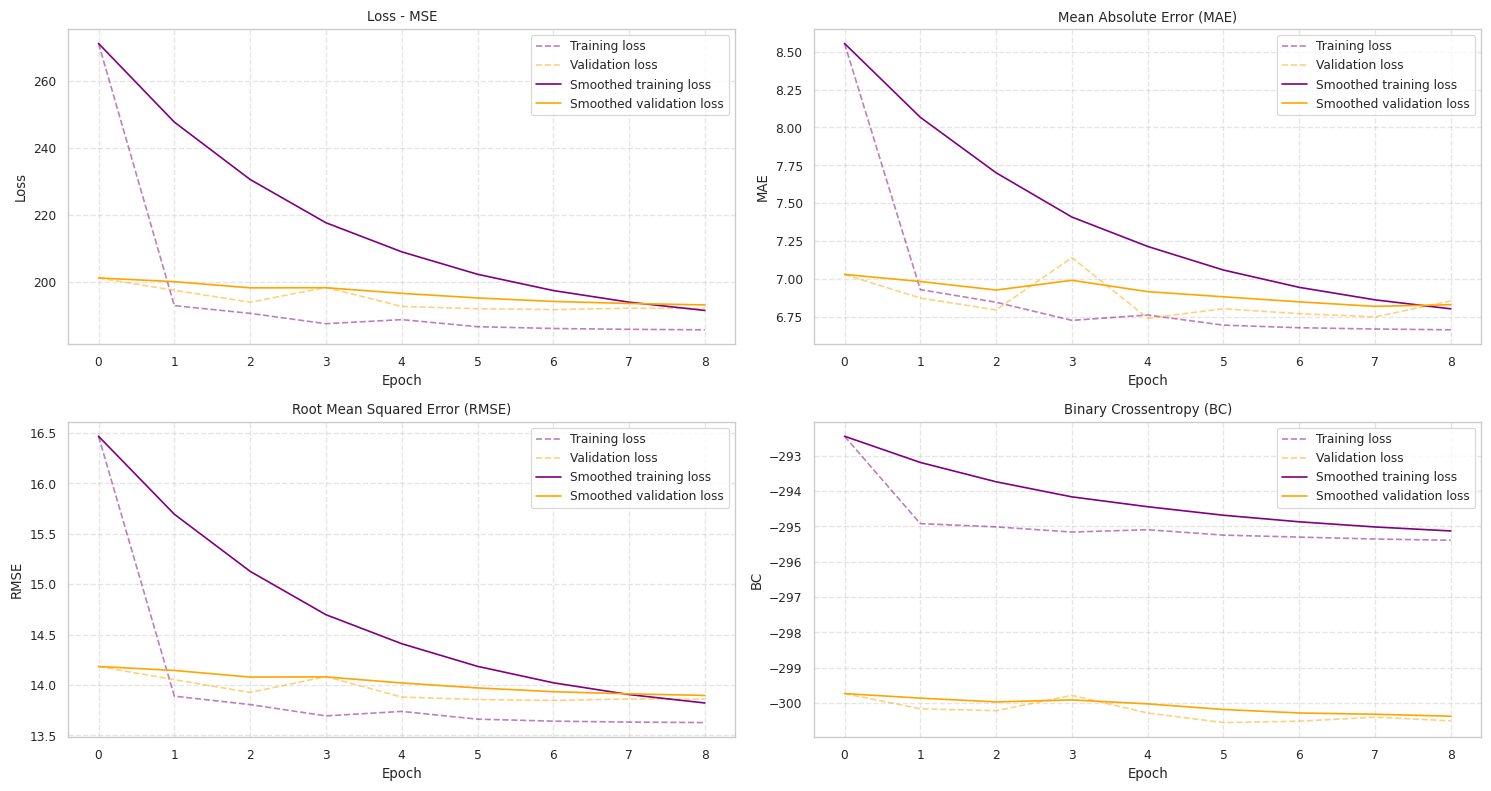

In [13]:
autoencoder.plot_history()

In [26]:
def load_model(model_name, directory='./saved_models'):
    """
    Load a trained model, configuration dictionaries, and training history from a directory.

    Args:
        model_name (str): Base name of the saved files (without extension).
        directory (str): Directory path where the model and configuration files are located.

    Returns:
        AutoEncoder: An AutoEncoder instance with the loaded model and configurations.
    """
    # Check if the directory exists
    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist. Unable to load model, configurations, and training history.")
        return None

    # Load the model from the h5 file
    model_file_path = os.path.join(directory, f"{model_name}.h5")
    if not os.path.exists(model_file_path):
        print(f"Model file {model_file_path} does not exist. Unable to load the model.")
        return None
    loaded_model = keras.models.load_model(model_file_path)
    loaded_encoder = keras.models.load_model(os.path.join(directory, f"{model_name}_encoder.h5"))
    loaded_decoder = keras.models.load_model(os.path.join(directory, f"{model_name}_decoder.h5"))

    # Load the configuration dictionaries and training history from the JSON file
    configs_file = os.path.join(directory, f"{model_name}_configs.json")
    if not os.path.exists(configs_file):
        print(f"Configurations file {configs_file} does not exist. Unable to load the configurations.")
        return None

    with open(configs_file, 'r') as f:
        all_data = json.load(f)

    # Create an AutoEncoder instance with the loaded model and configurations
    loaded_autoencoder = AutoEncoder()
    loaded_autoencoder.model = loaded_model
    loaded_autoencoder.encoder = loaded_encoder
    loaded_autoencoder.decoder = loaded_decoder
    loaded_autoencoder.model_config = all_data["model_config"]
    loaded_autoencoder.encoder_config = all_data["encoder_config"]
    loaded_autoencoder.decoder_config = all_data["decoder_config"]
    loaded_autoencoder.train_config = all_data["train_config"]
    loaded_autoencoder.history = all_data["history"]

    # #convert history from string to list of floats
    # for key, value in loaded_autoencoder.history.items():
    #     loaded_autoencoder.history[key] = eval(value)

    print(f"Model, configurations, and training history loaded from {directory}/{model_name}")
    return loaded_autoencoder


In [14]:
directory = './saved_models'
file_name = 'autoencoder_2_'
autoencoder.save_model(directory=directory, file_name=file_name)

Model and configs saved to ./saved_models

In [20]:
# del autoencoder
autoencoder = load_model(model_name=file_name, directory=directory)

Model, configurations, and training history loaded from ./saved_models/autoencoder_test_int_1

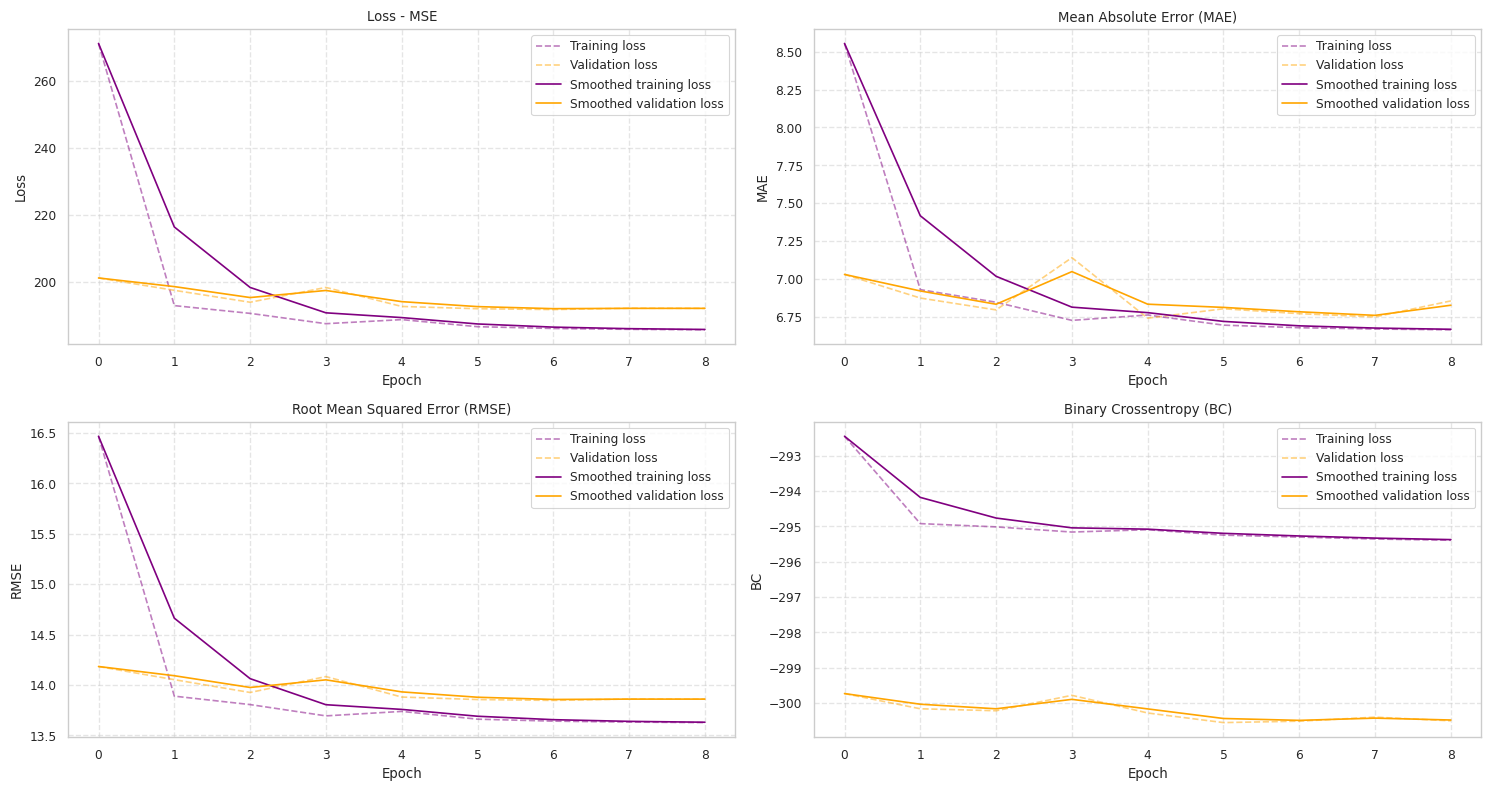

In [15]:
autoencoder.plot_history(smoothing = 0.3)

[ 2863  8526 11904  7994 13264  9868  9937   556  9395 13094]

1/1 [==============================] - 0s 223ms/step


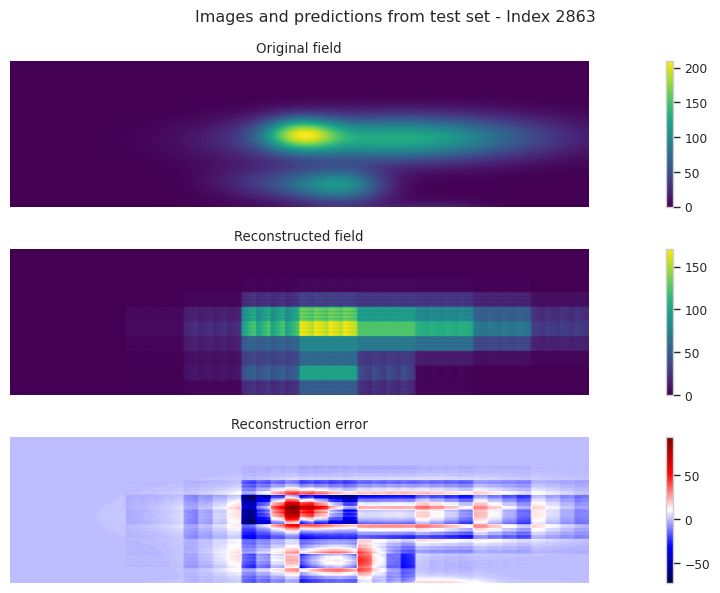

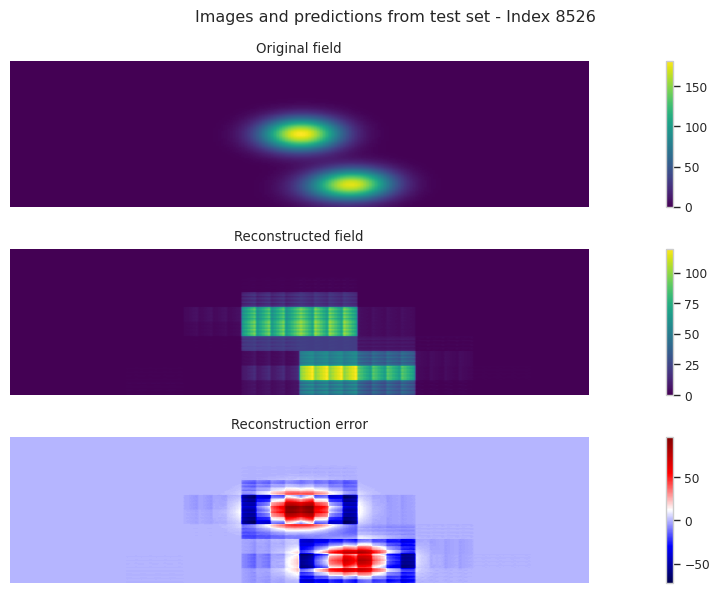

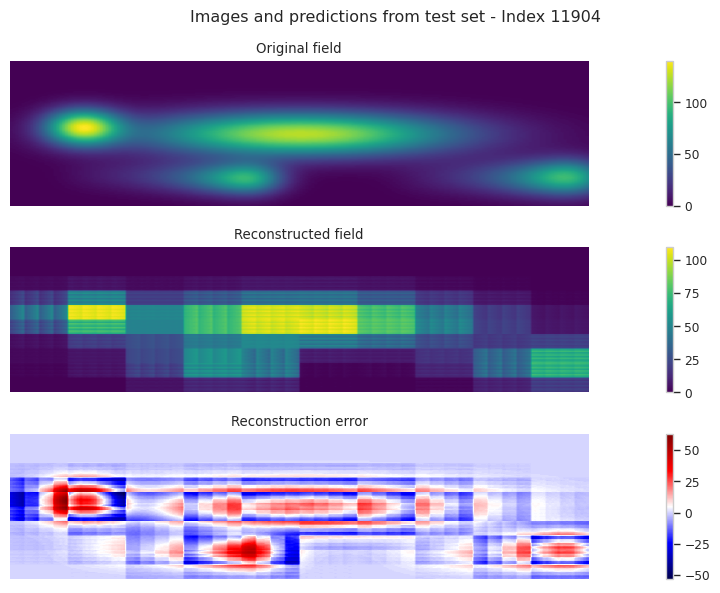

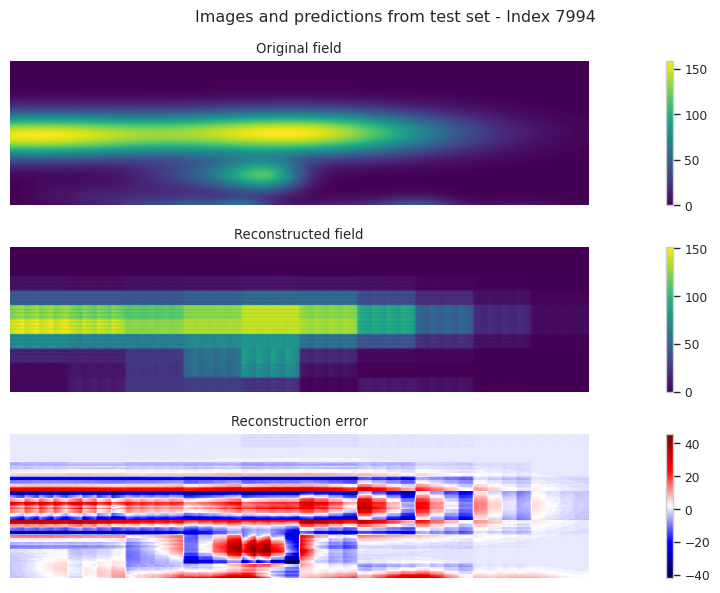

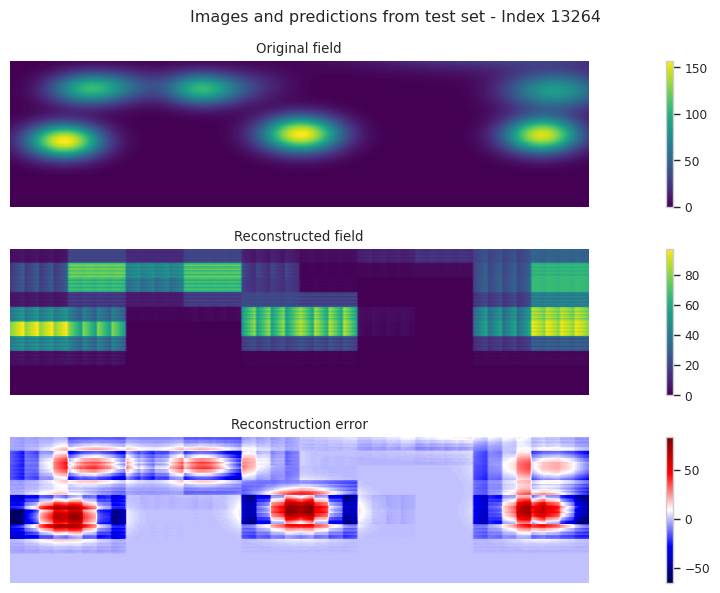

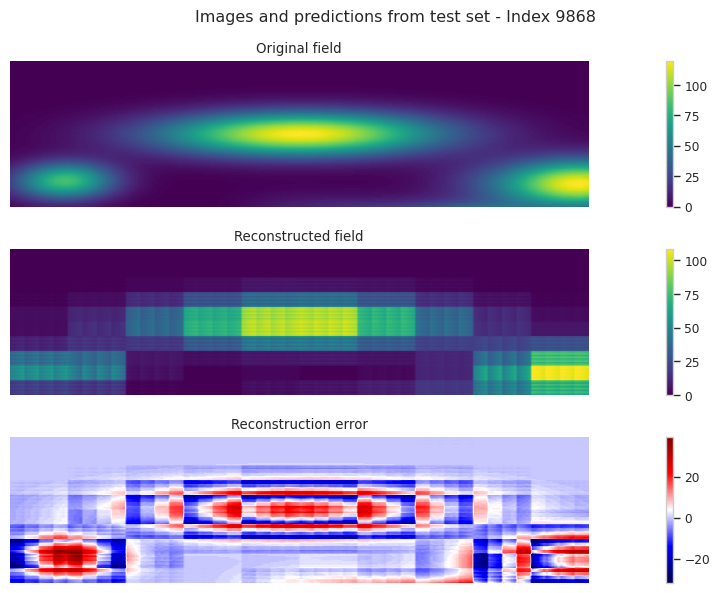

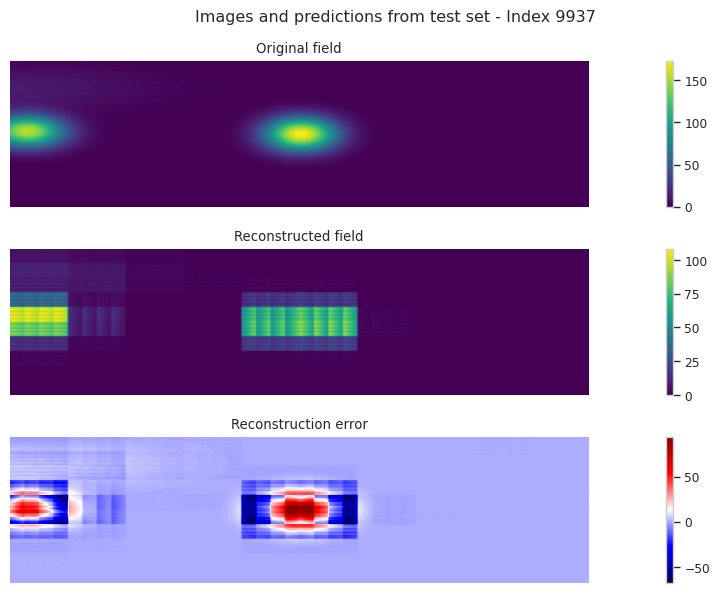

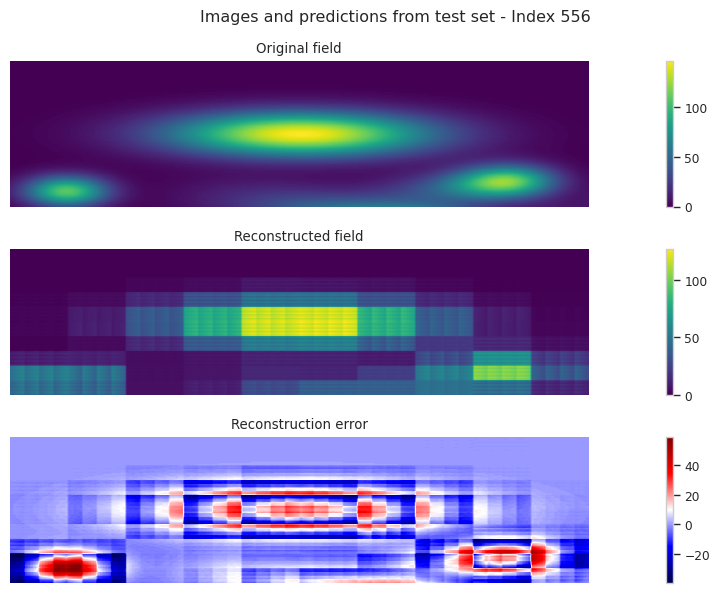

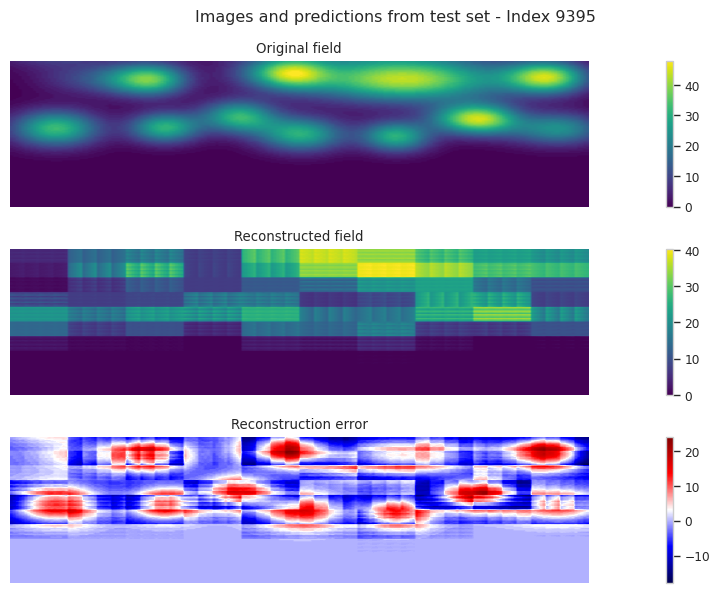

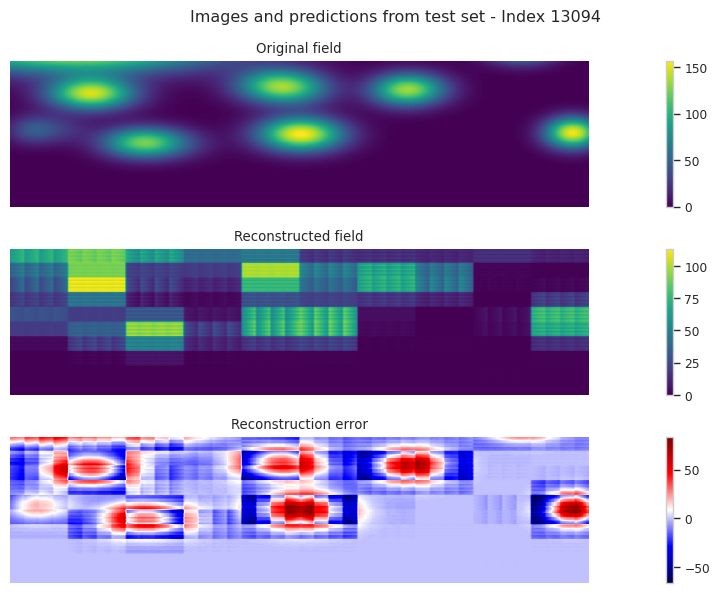

In [16]:
autoencoder.compare(test_data, num_plots=10)